In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import seaborn as sns
import math
from tqdm.notebook import tqdm

Conference Paper: https://indico.jlab.org/event/459/contributions/11832/ \
Beamsplitter Decomposition Paper: https://arxiv.org/pdf/2212.07389.pdf \
Beamsplitter Qumode Explanation: https://quantumcomputing.stackexchange.com/questions/32286/how-to-represent-beam-splitter-and-kerr-gates-as-basic-quantum-logic-gates\ \
QViT Paper: https://arxiv.org/pdf/2209.08167.pdf \

In [2]:

def Loader_BS(X):
    qml.PauliX(wires=0)
    for i,x in enumerate(X):
        # if X[i]!=X.max():
        qml.Beamsplitter(X[i]/X.max(),0,[i,i+1])
def MMULT_BS(phi,X,length=3):

    k=0
    Loader_BS(X)
    for i in range(2*length-2):
        j = length-abs(length-1-i)
        
        if i%2: 
            for _ in range(j):
                if _%2==0:
                    qml.Beamsplitter(phi[k], 0, [_,_+1])
                    k+=1
        else:
            for _ in range(j): 
                if _%2:
                    qml.Beamsplitter(phi[k], 0, [_,_+1])
                    k+=1
    return qml.expval(qml.PauliZ([1]))

In [3]:
import itertools

def plot_opm(op,args,wire_order=None):
    m_ = qml.matrix(op,wire_order=None)(*args).real.detach().numpy()
    q_n = int( np.log2(m_.shape[0]))
    plt.imshow(m_ ,cmap='RdBu',vmin=-1,vmax=1)
    labels =tick_label_gen(q_n)
    labels= [ labels[l] if np.abs(m_[:,0][l])>.01 else '' for l in range(len(labels)) ]
    
    ticks = [i for i in range(2**q_n)]
    plt.xticks(ticks,labels ,rotation='vertical')
    plt.yticks(ticks,labels)
    plt.colorbar()
    
tick_label_gen = lambda n: [str(i[::-1]) for i in itertools.product(*[[0,1] for i in range(n)])]


In [ ]:
phi  =torch.tensor([.1,.1,.1],requires_grad=True)
X = torch.tensor([[1,1,0],[0,1,1],[1,1,1]],requires_grad=False)
Y = torch.tensor([[1,0,0],[0,1,0],[0,0,1]],requires_grad=False)
X[1:]=1
alphas = torch.stack([calc_alphas(x) for x in X])

mag_alphas = calc_alphas( (X**2).sum(axis=1).sqrt() )

nrow,ncolumn = X.shape
mag_wires = [ '||X||_'+str(i) for i in range (nrow)]
wires = [ str(i) for i in range (ncolumn)]

In [4]:
def calc_alphas(X):
    alphas = torch.zeros(X.shape[0]-1)
    temp = X/(X**2).sum().sqrt()
    for i,x in enumerate(temp[:-1]):
        if i==0:
            alphas[i] = torch.acos(x)
         
        else:

            alphas[i] = torch.acos(x/(1-(temp[:i]**2).sum()).sqrt() )
            if torch.isnan(alphas[i]): alphas[i] = torch.acos(torch.ones(1))
    return alphas


def RBS(wires,th):
    qml.Hadamard(wires[0])
    qml.Hadamard(wires[1])
    qml.CZ(wires)
    qml.RY( th,wires[0])
    qml.RY(-th,wires[1])
    qml.CZ(wires)
    qml.Hadamard(wires[0])
    qml.Hadamard(wires[1])



def Vector_Loader(alphas,wires=None,is_x=True):

    if type(wires)==type(None): wires = [ i for i in range(len(alphas)+1)]
    if is_x:qml.PauliX(wires=wires[0])
    for i,x in enumerate(alphas):
        RBS([wires[i],wires[i+1]],x)

dev = qml.device('default.qubit',wires=wires+mag_wires, shots=5000)
@qml.qnode(dev,interface='torch')
def Matrix_Loader(mag_alphas,alphas,mag_wires,wires):
    Vector_Loader(mag_alphas,mag_wires)
    for i in range(len(mag_wires)):
        qml.CNOT([mag_wires[i],wires[0]])
        Vector_Loader(alphas[i],wires,is_x=False)
        if i != len(mag_alphas):Vector_Loader(-alphas[i+1],wires,is_x=False)

        
    # return qml.expval(qml.PauliZ([wires[0]]))
        
    return qml.state()

def MMULT(phi,alpha_x,wire_to_measure,length):
    

    k=0
    if type(alpha_x)!='NoneType': Vector_Loader(alpha_x)
    for i in range(2*length-2):
        j = length-abs(length-1-i)
        
        if i%2: 
            for _ in range(j):
                if _%2==0:
                    RBS([_,_+1],phi[k])
                    k+=1
        else:
            for _ in range(j): 
                if _%2:
                    RBS([_,_+1],phi[k])
                    k+=1
    return qml.expval(qml.PauliZ([wire_to_measure]))


NameError: name 'wires' is not defined

In [ ]:
alphas[0]

In [ ]:
plot_opm(Vector_Loader,(mag_alphas,mag_wires,True),wire_order = mag_wires+wires)

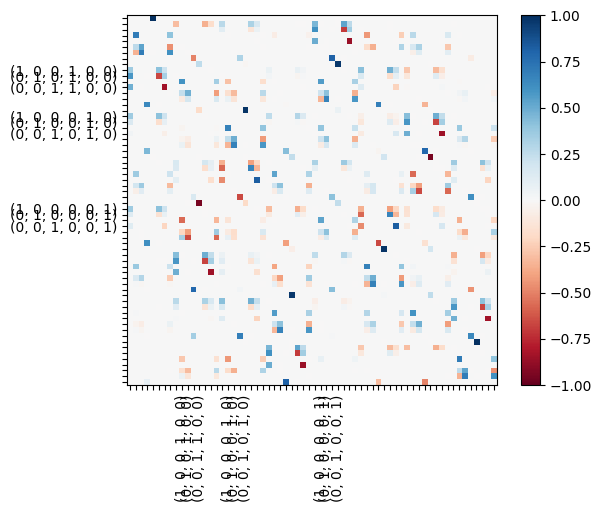

In [305]:
plot_opm(Matrix_Loader,(mag_alphas,alphas,mag_wires,wires),wire_order = mag_wires+wires)

In [299]:
qml.state?

Signature: qml.state()
Docstring:
Quantum state in the computational basis.

This function accepts no observables and instead instructs the QNode to return its state. A
``wires`` argument should *not* be provided since ``state()`` always returns a pure state
describing all wires in the device.

Note that the output shape of this measurement process depends on the
number of wires defined for the device.

Returns:
    StateMP: Measurement process instance

**Example:**

.. code-block:: python3

    dev = qml.device("default.qubit", wires=2)

    @qml.qnode(dev)
    def circuit():
        qml.Hadamard(wires=1)
        return qml.state()

Executing this QNode:

>>> circuit()
array([0.70710678+0.j, 0.70710678+0.j, 0.        +0.j, 0.        +0.j])

The returned array is in lexicographic order. Hence, we have a :math:`1/\sqrt{2}` amplitude
in both :math:`|00\rangle` and :math:`|01\rangle`.

.. note::

    Differentiating :func:`~pennylane.state` is currently only supported when using the
    

In [300]:
Matrix_Loader(mag_alphas,alphas,mag_wires,wires).abs()

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5355e-01, 5.8122e-01, 0.0000e+00,
        4.8322e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5355e-01,
        1.4312e-01, 0.0000e+00, 3.4437e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5355e-01, 1.2921e-01, 0.0000e+00,
        1.2374e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7756e-17, 0.0000e+00, 0.0000e+00,
        5.5511e-17, 0.0000e+00, 0.0000e+00, 0.0000e+00], dtype=torch.float64)

In [293]:
X/(X**2).sum().sqrt()

tensor([[0.3536, 0.3536, 0.0000],
        [0.3536, 0.3536, 0.3536],
        [0.3536, 0.3536, 0.3536]])

(<Figure size 6500x700 with 1 Axes>, <Axes: >)

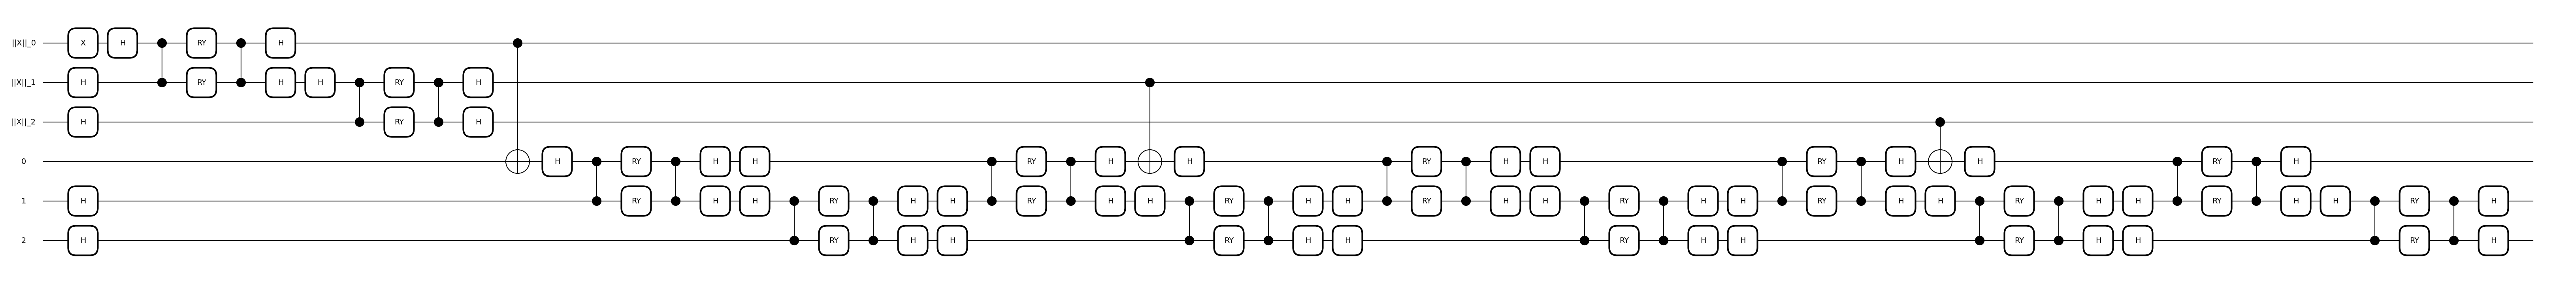

In [258]:

qml.draw_mpl(Matrix_Loader,show_all_wires=True)(mag_alphas,alphas,mag_wires,wires)

As of now, I am trying to implement the QViT paper.\\

The main gist of the paper is to use quantum circuits to load the input in the form of a $\bf{matrix}$ then multiply it by a learnable orthogonal matrix.
For now, I'm trying to load a $\bf{vector}$ using their method then perform the matrix multiplication.


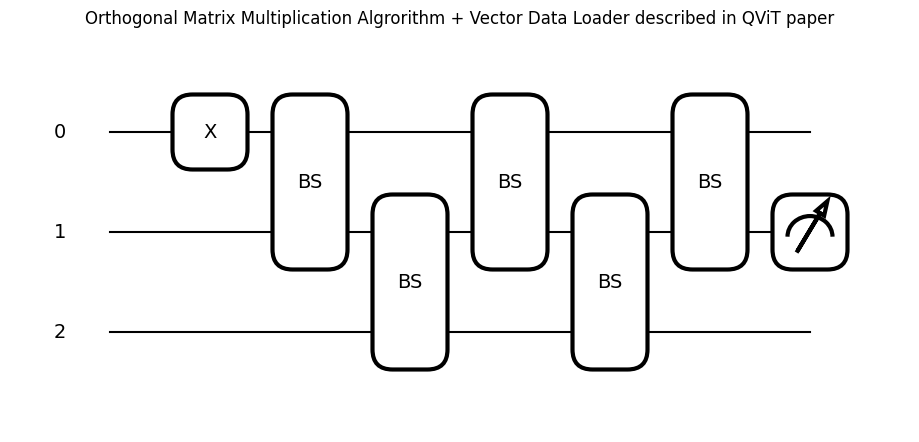

In [43]:
qml.draw_mpl(MMULT_BS,show_all_wires=True,wire_order=[i for i in range(len(X))])(torch.zeros(10),torch.ones(2))
q=plt.title('Orthogonal Matrix Multiplication Algrorithm + Vector Data Loader described in QViT paper')

Text(0.5, 1.0, 'BeamSplitter Equivalent Structure')

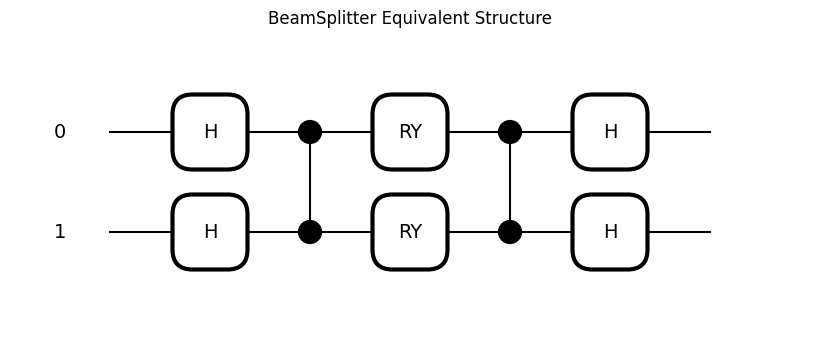

In [44]:
qml.draw_mpl(RBS,show_all_wires=True)([0,1],torch.tensor([0]))
plt.title('BeamSplitter Equivalent Structure')

In [45]:
qml.draw_mpl(Vector_Loader,show_all_wires=True,wire_order=[i for i in range(3)])(torch.ones(2))
q=plt.title('Data Loader in Qubit Form')

QuantumFunctionError: A quantum function must return either a single measurement, or a nonempty sequence of measurements.

Suggested data loader takes n-1 parameters to load length n data.
Data loader circuit can be expressed as the following.

$$\Psi = \left[\Sigma_{i=0}^{n-2} \left(\Pi^{i-1}_{j=0}\sin \alpha_j \right)e_i \cos \alpha_i \right]+\left(\Pi^{n-1}_{j=0}\sin \alpha_j \right)e_{n-1}$$.
Therefore, one can load normalized vector $x_i$ using the following parameters:
$$\alpha_0 = cos^{-1}(x_0)$$
$$\alpha_i = cos^{-1}\left(x_i / \left[1-\Sigma_{j=0}^{i-1}x_j^2\right]^{-1/2}\right)$$


8


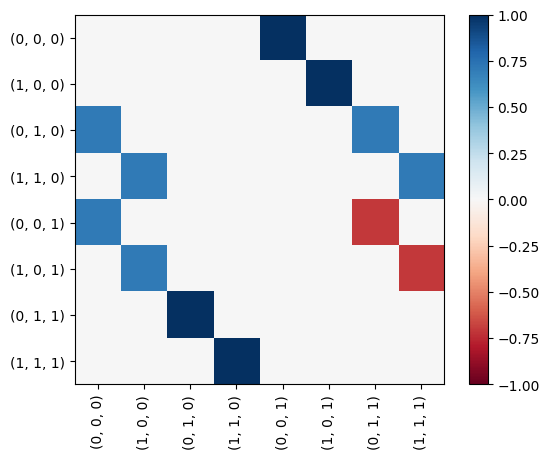

In [86]:
# Plots real component of the operator/circuit given with the arguements.

test_x = torch.tensor([1,1,0])    
plot_opm(Vector_Loader,[calc_alphas(test_x)])


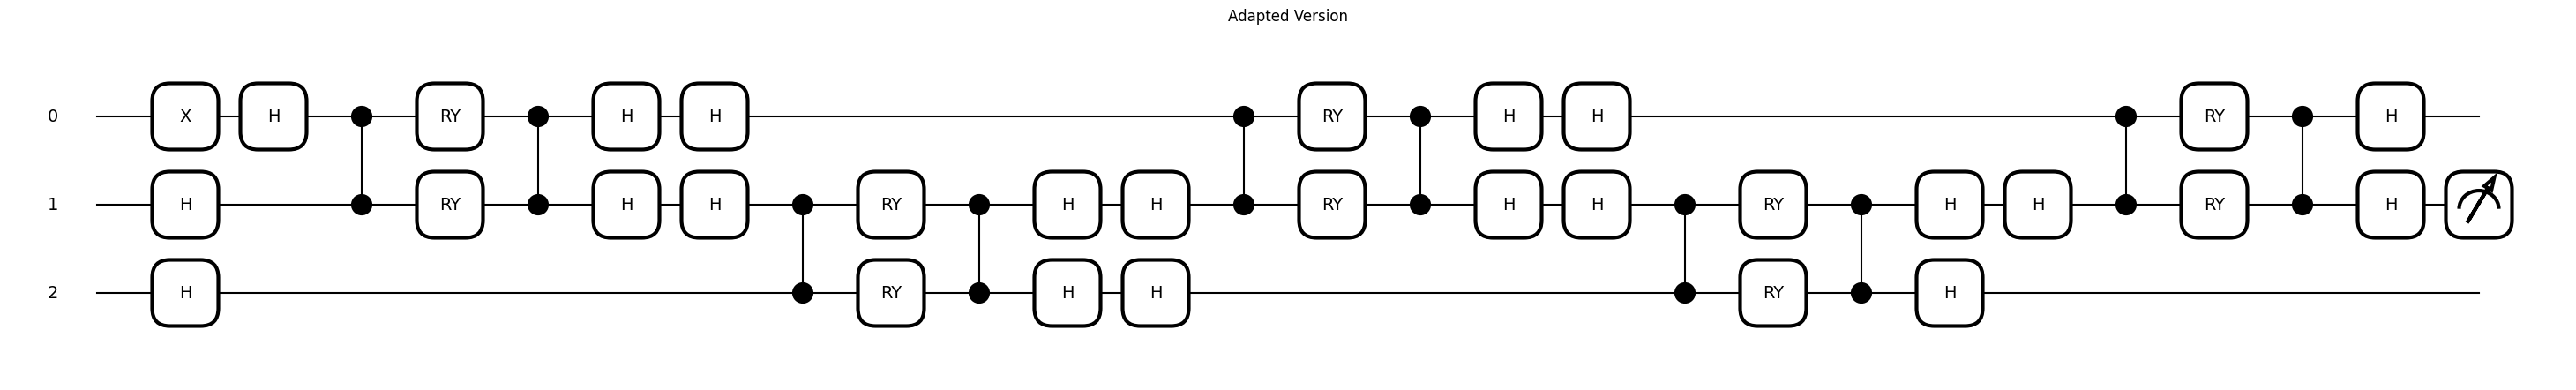

In [87]:
qml.draw_mpl(MMULT,show_all_wires=True,wire_order=[i for i in range(len(X))])(torch.zeros(10),torch.zeros(2),wire_to_measure=1,length=3)
q=plt.title('Adapted Version')

In [89]:
phi  =torch.tensor([.1,.1,.1],requires_grad=True)
X = torch.tensor([[1,0,0],[0,1,0],[0,0,1]],requires_grad=False)
Y = torch.tensor([[1,0,0],[0,1,0],[0,0,1]],requires_grad=False)
alpha_x = torch.stack([calc_alphas(X[i]) for i in range(3)])

In [96]:
from math import sqrt
phi = torch.normal(0,torch.ones(3)*1/sqrt(3)).requires_grad_(True)
def loss_fn(Xp,y):
    return ((Xp.real-y)**2).sum()
optim = torch.optim.Adam([phi],lr=5e-3)
bar =tqdm(range(500))
for ii in bar:
    # loss=0
    

    optim.zero_grad()
    phi_s = phi.clone()
    Xp = torch.stack([torch.sqrt((1-MMULT(phi,alpha_x[i],j,length=n_q))/2+1e-7) for i in range(3) for j in range(3)]).reshape(3,3)
    loss_ = loss_fn(Xp,X)
    loss_.backward()
        # loss+=loss_.item()
    optim.step()
    if torch.isnan(phi).any(): break
    bar.set_postfix_str('{:.5e}'.format(loss_.sum().item()))

  0%|          | 0/500 [00:00<?, ?it/s]

In [94]:
torch.stack([torch.sqrt((1-MMULT(phi_s,alpha_x[i],j,length=3))/2) for i in range(3) for j in range(3)]).reshape(3,3)

tensor([[1.0000e+00, 3.1759e-04, 3.1759e-04],
        [3.6755e-04, 1.0000e+00, 3.6755e-04],
        [4.1149e-04, 4.1149e-04, 1.0000e+00]], dtype=torch.float64,
       grad_fn=<ReshapeAliasBackward0>)

8


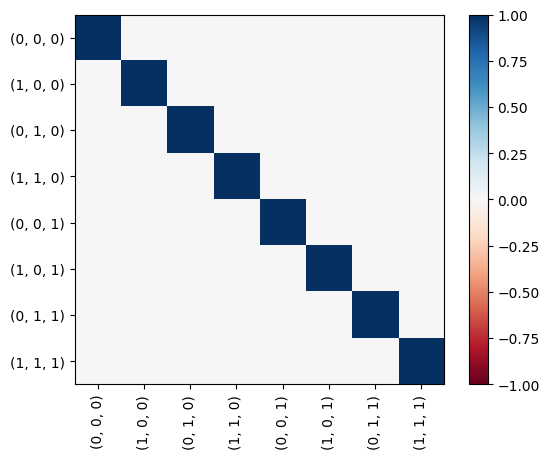

In [95]:
# plt.imshow(qml.matrix(display_MMULT)(phi_s).detach().numpy().real,cmap='RdBu',vmin=-1,vmax=1)

# n_q = 3
# labels =tick_gen(n_q)
# ticks = [i for i in range(2**n_q)]
# plt.xticks(ticks,labels ,rotation='vertical')

# plt.yticks(ticks,labels)

# plt.colorbar()
plot_opm(display_MMULT,[phi_s])

There is a limitation that we can only access to the magnitude of the product, the following paper suggests a method to obtain the sign. I haven't got a chance to read it.
https://arxiv.org/pdf/2109.01831.pdf

# Future Goal's

-Figure out how to get the sign of the inner product

-Construct a single head few layers transformer

-Look for alternative ways for a transformer

# Junk

In [23]:
dev = qml.device('default.qubit', wires=2, shots=1000)
@qml.qnode(dev,interface='torch')
def RBS(wires,th):
    
    qml.Hadamard(wires[0])
    qml.Hadamard(wires[1])
    qml.CZ(wires)
    qml.RY( th,wires[0])
    qml.RY(-th,wires[1])
    qml.CZ(wires)
    qml.Hadamard(wires[0])
    qml.Hadamard(wires[1])
    return qml.state()

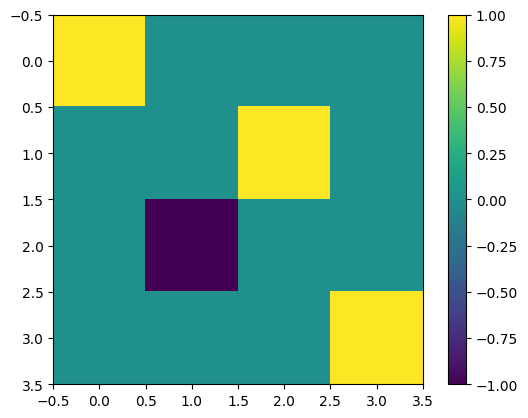

In [26]:
plt.imshow(qml.matrix(RBS)([0,1],np.pi/2).real)
plt.colorbar()